# ClimateNet AR Analysis: MERRA data subset for ARs

In [1]:
import numpy as np
import xarray as xr
import matplotlib.pyplot as plt
import xesmf as xe
import nc_time_axis
import cftime 
import cartopy.crs as ccrs
import cartopy.feature as cfeature
from cartopy.util import add_cyclic_point
import matplotlib.colors as mcolors
import matplotlib as mpl
import datetime
import pandas as pd

In [2]:
# Import dask
import dask

# Use dask jobqueue
from dask_jobqueue import PBSCluster

# Import a client
from dask.distributed import Client

# Setup your PBSCluster
nmem1 = '10GiB' # PBSCluster specification
nmem2 = '10GB' # pbs specification
cluster = PBSCluster(
    cores=1, # The number of cores you want
    memory=nmem1, # Amount of memory
    processes=1, # How many processes
    queue='casper', # The type of queue to utilize (/glade/u/apps/dav/opt/usr/bin/execcasper)
    local_directory='/glade/derecho/scratch/kdagon/dask-local', # Use your local directory
    resource_spec='select=1:ncpus=1:mem='+nmem2, # Specify resources
    account='P06010014', # Input your project ID here
    walltime='04:00:00', # Amount of wall time
    interface='ext', # Interface to use
)

# Scale up
cluster.scale(30) # 25 (at least) for processing 3hrly data
#cluster.scale(10) # for other tasks

# Change your url to the dask dashboard so you can see it
#dask.config.set({'distributed.dashboard.link':'https://jupyterhub.hpc.ucar.edu/stable/user/{USER}/proxy/{port}/status'})

# Setup your client
client = Client(cluster)

Task exception was never retrieved
future: <Task finished name='Task-83050' coro=<Client._gather.<locals>.wait() done, defined at /glade/work/kdagon/conda-envs/PEx_v2/lib/python3.11/site-packages/distributed/client.py:2208> exception=AllExit()>
Traceback (most recent call last):
  File "/glade/work/kdagon/conda-envs/PEx_v2/lib/python3.11/site-packages/distributed/client.py", line 2217, in wait
    raise AllExit()
distributed.client.AllExit


In [3]:
client

Connection method: Cluster object,Cluster type: dask_jobqueue.PBSCluster
Dashboard: https://jupyterhub.hpc.ucar.edu/stable/user/kdagon/Casper CPU CCR/proxy/8787/status,
Dashboard: https://jupyterhub.hpc.ucar.edu/stable/user/kdagon/Casper CPU CCR/proxy/8787/status,Workers: 0
Total threads: 0,Total memory: 0 B
Comm: tcp://128.117.208.100:39355,Workers: 0
Dashboard: https://jupyterhub.hpc.ucar.edu/stable/user/kdagon/Casper CPU CCR/proxy/8787/status,Total threads: 0
Started: Just now,Total memory: 0 B


## MERRA ARs

In [4]:
merra_cnet_path = '/glade/derecho/scratch/shields/ARTMIP/catalogues/tier1/ClimateNet_DL/' # tier1, 3hrly
#merra_cnet_path = '/glade/derecho/scratch/shields/ARTMIP/catalogues/tier2/MERRA2_native/climatenet/' # tier2, 1hrly

In [5]:
file_years = '*.20[00-15]*' # not a perfect wildcard, but captures 2000 - 2017 (or 2019 for tier2)
#file_years = '*.nc4' # for all years; 1980 - June 2017

### Preprocessing function to (optionally) subset regionally

In [6]:
# MERRA2 lons are -180 / +180
lat_bounds_merra = slice(25,65)
lon_bounds_merra = slice(-180,-105)

In [7]:
def preprocess_region_merra(ds):
    # return regional domain
    return ds['ar_binary_tag'].sel(lat=lat_bounds_merra,lon=lon_bounds_merra)

### Read in data

In [8]:
#merra_cnet = xr.open_mfdataset(merra_cnet_path+file_years, concat_dim='time', combine='nested', chunks={'time':500}, parallel=True)
merra_cnet = xr.open_mfdataset(merra_cnet_path+file_years, concat_dim='time', combine='nested', chunks={'time':500}, parallel=True, preprocess=preprocess_region_merra)
merra_cnet

<xarray.DataArray 'ar_binary_tag' (time: 51128, lat: 81, lon: 121)>
dask.array<concatenate, shape=(51128, 81, 121), dtype=int8, chunksize=(500, 81, 121), chunktype=numpy.ndarray>
Coordinates:
  * lat      (lat) float32 25.0 25.5 26.0 26.5 27.0 ... 63.0 63.5 64.0 64.5 65.0
  * lon      (lon) float32 -180.0 -179.4 -178.8 -178.1 ... -106.2 -105.6 -105.0
  * time     (time) datetime64[ns] 2000-01-01 ... 2017-06-30T21:00:00
Attributes:
    version:      CGNet
    scheme:       ClimateNet_DL_model
    description:  binary indicator of atmospheric river

In [9]:
# if not using preprocess
#merra_ar_full = merra_cnet.ar_binary_tag

# otherwise
merra_ar_full = merra_cnet
#merra_ar_full

In [10]:
# subset 2000-2015 to match CESM years (number of time indices will not match due to CESM shifted start and MERRA leap years)
merra_ar = merra_ar_full.sel(time=slice("2000","2015"))

# or look at all years
#merra_ar = merra_ar_full

merra_ar

<xarray.DataArray 'ar_binary_tag' (time: 46752, lat: 81, lon: 121)>
dask.array<getitem, shape=(46752, 81, 121), dtype=int8, chunksize=(500, 81, 121), chunktype=numpy.ndarray>
Coordinates:
  * lat      (lat) float32 25.0 25.5 26.0 26.5 27.0 ... 63.0 63.5 64.0 64.5 65.0
  * lon      (lon) float32 -180.0 -179.4 -178.8 -178.1 ... -106.2 -105.6 -105.0
  * time     (time) datetime64[ns] 2000-01-01 ... 2015-12-31T21:00:00
Attributes:
    version:      CGNet
    scheme:       ClimateNet_DL_model
    description:  binary indicator of atmospheric river

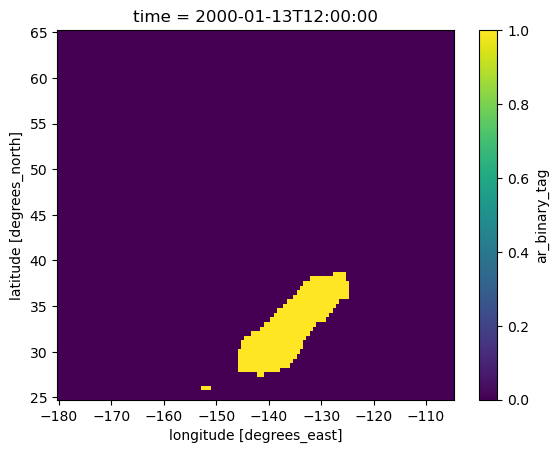

In [44]:
merra_ar.isel(time=100).plot();

## MERRA 3hrly data

In [11]:
merra_data_path = "/glade/campaign/cgd/ccr/shields/MERRA2/ARTMIP/MERRA_UV/" # U/V850 in one file; time as "record" dimension, 1980-2017

In [12]:
# for single u/v850 file
merra_data_file = "ARTMIP_MERRA2_shields_uv850_1980-2017.nc"

### Read in data

In [13]:
%%time
# single file for u/v850
merra_dataset = xr.open_dataset(merra_data_path+merra_data_file, chunks='auto') # auto chunking worked well here for the 3 variables in this file, fast to read in
#merra_dataset

CPU times: user 906 ms, sys: 232 ms, total: 1.14 s
Wall time: 1.35 s


### Rename record dim

In [14]:
merra_dataset = merra_dataset.rename({'record': 'time'})
#merra_dataset

### Fix datetime

In [15]:
# create datetimes for merra data
merra_dt = np.arange(np.datetime64('1980-01-01T00:00:00.000000000'), np.datetime64('2017-07-01T00:00:00.000000000'), np.timedelta64(3, "h"))
#len(merra_dt)

# assign to merra data
merra_dataset['time'] = merra_dt
#merra_dataset

### Subset for CESM years

In [16]:
merra_subset = merra_dataset.sel(time=slice('2000-01-01', '2015-12-31'))
#merra_subset

### Masking NANs

In [17]:
merra_subset_masked = merra_subset.isel(lev=0).where(merra_subset.isel(time=0, lev=0).notnull())
#merra_subset_masked

### Subset region

In [18]:
merra_subset_region = merra_subset_masked.sel(lat=lat_bounds_merra,lon=lon_bounds_merra)
#merra_subset_region

### Time mean

In [19]:
merra_subset_region_mean = merra_subset_region.mean(dim='time').rename({'u':'U850', 'v': 'V850'})
#merra_subset_region_mean

## MERRA data and ARs

In [20]:
merra_data_AR = merra_subset_region.where(merra_ar==1)
#merra_data_AR

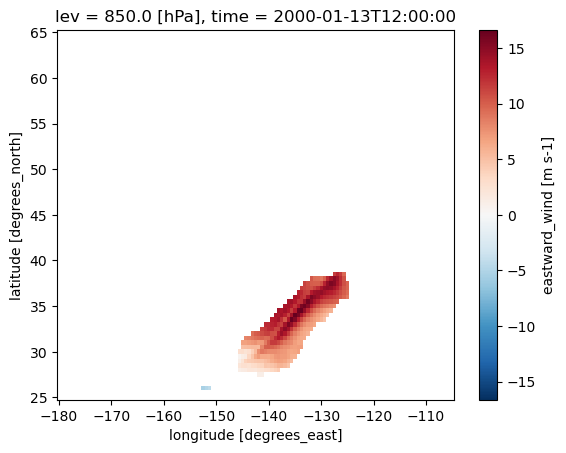

In [25]:
merra_data_AR['u'].isel(time=100).plot();

### Time mean

In [21]:
merra_data_AR_mean = merra_data_AR.mean(dim='time').rename({'u':'U850', 'v': 'V850'})
#merra_data_AR_mean

In [28]:
#merra_data_AR_mean = merra_data_AR_mean.persist()

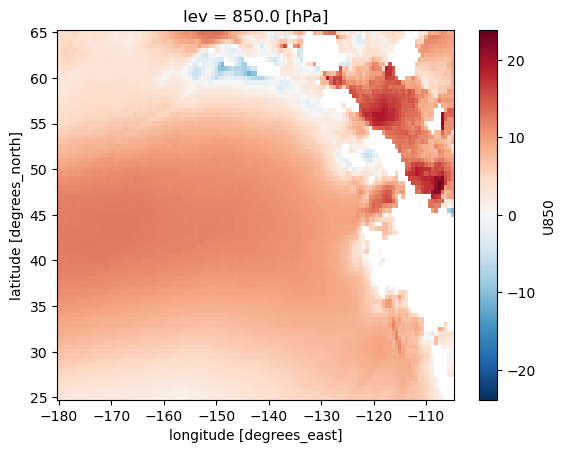

In [27]:
#merra_data_AR_mean['U850'].plot();

### Compare AR timepoints to all timepoints
Only run these if you persisted `merra_data_AR_mean` above

In [ ]:
for i, var in enumerate(('IWV', 'U850', 'V850')):
    print(var)
    print('AR timepoint ranges ',merra_data_AR_mean[var].min().values, merra_data_AR_mean[var].max().values)
    print('All timepoint ranges ',merra_subset_region_mean[var].min().values, merra_subset_region_mean[var].max().values)

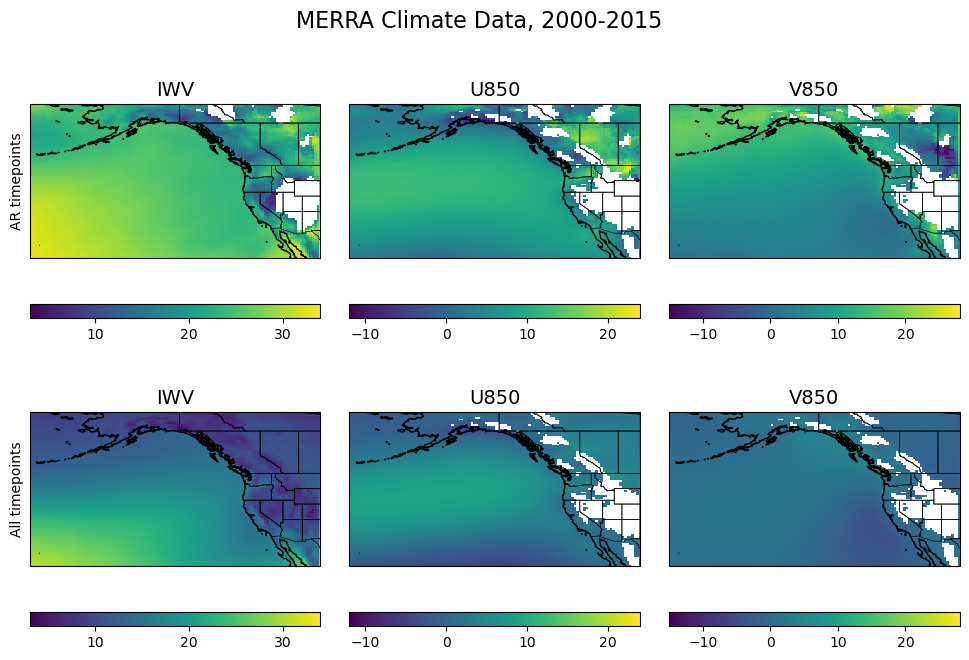

In [30]:
fig, axs = plt.subplots(2, 3, figsize=(12,8), subplot_kw={'projection': ccrs.PlateCarree(central_longitude=180.0)})

axs = axs.ravel()

# colormap
#cmap=plt.cm.get_cmap('viridis')
cmap = mpl.colormaps['viridis']

for i, var in enumerate(('IWV', 'U850', 'V850')):
    if i==0:
        vmin=3
        vmax=34
    if i==1:
        vmin=-12
        vmax=24
    if i==2:
        vmin=-15
        vmax=28
    field, lon = add_cyclic_point(merra_data_AR_mean[var], coord=merra_data_AR_mean.lon)
    lat = merra_data_AR_mean.lat
    pc = axs[i].pcolormesh(lon, lat, field, cmap=cmap, vmin=vmin, vmax=vmax, transform=ccrs.PlateCarree())
    axs[i].coastlines(zorder=1)
    axs[i].add_feature(cfeature.STATES, zorder=2, linewidth=0.5)
    axs[i].set_title(var, fontsize=14)
    axs[i].set_yticks([])
    if i==0:
        axs[i].set_ylabel('AR timepoints')
    axs[i].set_extent((lon[0],lon[-1],lat[0],lat[-1]), crs=ccrs.PlateCarree())
    fig.colorbar(pc, ax=axs[i], location='bottom')

for i, var in enumerate(('IWV', 'U850', 'V850')):
    if i==0:
        vmin=3
        vmax=34
    if i==1:
        vmin=-12
        vmax=24
    if i==2:
        vmin=-15
        vmax=28
    field, lon = add_cyclic_point(merra_subset_region_mean[var], coord=merra_subset_region_mean.lon)
    lat = merra_subset_region_mean.lat
    pc = axs[i+3].pcolormesh(lon, lat, field, cmap=cmap, vmin=vmin, vmax=vmax, transform=ccrs.PlateCarree())
    axs[i+3].coastlines(zorder=1)
    axs[i+3].add_feature(cfeature.STATES, zorder=2, linewidth=0.5)
    axs[i+3].set_title(var, fontsize=14)
    axs[i+3].set_yticks([])
    axs[i+3].set_extent((lon[0],lon[-1],lat[0],lat[-1]), crs=ccrs.PlateCarree())
    if i==0:
        axs[i+3].set_ylabel('All timepoints')
    fig.colorbar(pc, ax=axs[i+3], location='bottom')

# add colorbar for absolute plots
#cb_ax = fig.add_axes([0.16, 0.08, 0.7, 0.02])
#norm = mpl.colors.Normalize(vmin=0, vmax=vmax)
#cb = mpl.colorbar.ColorbarBase(cb_ax, cmap=cmap, norm=norm, orientation='horizontal')
#cb = mpl.colorbar.ColorbarBase(cb_ax, cmap=cmap, norm=norm, orientation='horizontal', extend='max')
#cb.ax.set_xlabel('%', fontsize=14)

# add title
fig.suptitle('MERRA Climate Data, 2000-2015', fontsize=16, y=0.92)

plt.subplots_adjust(wspace=0.1, hspace=0)

# reminder to set dpi=300 for publications
#plt.savefig('../figures/toSCP/MERRA_data_ARs.png', bbox_inches='tight')

### Seasonal means

In [23]:
merra_data_AR_smean = merra_data_AR.groupby('time.season').mean(dim='time').rename({'u':'U850', 'v': 'V850'})
#merra_data_AR_smean

In [24]:
merra_data_AR_smean = merra_data_AR_smean.persist()

## CESM ARs

### Set ClimateNet filepath

In [25]:
cesm_cnet_filepath = "/glade/campaign/cgd/ccr/kdagon/cgnet/" # retrained NCAR model, after data processing workflow was finalized

### Set regional bounds

In [26]:
# Western US domain from Payne & Magnusdottir (2014,2015) papers (estimated, modified to include land at all lons)
#lat_bounds = slice(25,61)
#lon_bounds = slice(189, 250)

# Restricted western US (mostly land) domain from Collow et al. 2020
#lat_bounds = slice(32,50)
#lon_bounds = slice(235,246)

# Western US/Eastern Pacific domain from ARTMIP
lat_bounds = slice(25,65)
lon_bounds = slice(180,255)

### Preprocessing function to subset regionally

In [27]:
def preprocess_region(ds):
    # return regional domain
    return ds['masks'].sel(lat=lat_bounds,lon=lon_bounds)

### CESM historical simulation

In [28]:
hist_yrs = [str(i) for i in range(2000,2006)]
#hist_folders = ["B20TRC5CN/"+y+"/masks/" for y in hist_yrs]
hist_folders = ["B20TRC5CN/"+y+"/masks_unwgt/" for y in hist_yrs] # unweighted means/std

In [29]:
cnet_file = 'class_masks.nc' # can't use wildcard for this to work?
hist_paths = [cesm_cnet_filepath+hist_folders[i]+cnet_file for i,f in enumerate(hist_folders)]
#hist_paths

#### Read in masks with preprocessing

In [30]:
%%time
cnet_hist_shift = xr.open_mfdataset(hist_paths, concat_dim='time',combine='nested', chunks={'time':500}, parallel=True, preprocess=preprocess_region)

CPU times: user 2.51 s, sys: 152 ms, total: 2.66 s
Wall time: 12.9 s


#### Shift time indices of 2000-2005 back 3hrs to avoid duplicative index

In [31]:
timeshift = cnet_hist_shift.sel(time=slice("2000-01-01 03:00:00","2006-01-01 00:00:00")).time.indexes['time'].shift(-3,"h")

In [32]:
cnet_hist = cnet_hist_shift.sel(time=slice("2000-01-01 03:00:00","2006-01-01 00:00:00")).assign_coords(time=timeshift)

### CESM RCP2.6 simulation

In [33]:
rcp26_yrs = [str(i) for i in range(2006,2016)]
#rcp26_folders = ["BRCP26C5CN/"+y+"/masks/" for y in rcp26_yrs]
#rcp26_folders = ["BRCP26C5CN/"+y+"/masks_v2/" for y in rcp26_yrs] # updated data processing (3hrly PSL)
rcp26_folders = ["BRCP26C5CN/"+y+"/masks_unwgt/" for y in rcp26_yrs] # unweighted means/std

In [34]:
cnet_file = 'class_masks.nc' # can't use wildcard for this to work?
rcp26_paths = [cesm_cnet_filepath+rcp26_folders[i]+cnet_file for i,f in enumerate(rcp26_folders)]
#rcp26_paths

#### Read in masks with preprocessing

In [35]:
%%time
cnet_rcp26 = xr.open_mfdataset(rcp26_paths, concat_dim='time',combine='nested', chunks={'time':500}, parallel=True, preprocess=preprocess_region)

CPU times: user 659 ms, sys: 24.8 ms, total: 684 ms
Wall time: 3.2 s


### Combine historical/RCP2.6

In [36]:
cnet_hist_rcp26 = xr.concat([cnet_hist, cnet_rcp26], dim='time')
#cnet_hist_rcp26

### Define ARs

In [37]:
cesm_AR = cnet_hist_rcp26.clip(min=1)-1
cesm_AR

<xarray.DataArray 'masks' (time: 46720, lat: 170, lon: 241)>
dask.array<sub, shape=(46720, 170, 241), dtype=int64, chunksize=(500, 170, 241), chunktype=numpy.ndarray>
Coordinates:
  * lon      (lon) float64 180.0 180.3 180.6 180.9 ... 254.1 254.4 254.7 255.0
  * lat      (lat) float64 25.23 25.46 25.7 25.93 ... 64.19 64.42 64.65 64.89
  * time     (time) object 2000-01-01 00:00:00 ... 2015-12-31 21:00:00

## CESM 3hrly data

In [38]:
cesm_data_path = "/glade/campaign/cgd/ccr/kdagon/cgnet/"

In [39]:
hist_folder = "B20TRC5CN/"
rcp26_folder = "BRCP26C5CN/"

In [40]:
hist_yrs = [str(i) for i in range(2000,2006)]
rcp26_yrs = [str(i) for i in range(2006,2016)]

In [41]:
cesm_files = '*.nc'
hist_paths = [cesm_data_path+hist_folder+y+'/'+cesm_files for y in hist_yrs]
#hist_paths

In [42]:
rcp26_paths = [cesm_data_path+rcp26_folder+y+'/'+cesm_files for y in rcp26_yrs]
#rcp26_paths

### Preprocessing functions to subset variables
TO DO: subset regions at this step? faster read in?

In [44]:
def preprocess_TMQ(ds):
    return ds['TMQ']

In [45]:
# having trouble reading in both at the same time, create separate u/v850 functions
def preprocess_U850(ds):
    return ds['U850']

def preprocess_V850(ds):
    return ds['V850']

In [152]:
def preprocess_PSL(ds):
    return ds['PSL']

### Read in historical files with preprocessing function
`xr.open_mfdataset` won't take a list of paths with wildcards, so have to feed each one and then concat\
There may be a fast way with some sort of list expansion / glob ?

In [46]:
%%time
TMQ_hist_list = []
for i,f in enumerate(hist_paths):
    #print(i)    
    TMQ_hist_temp = xr.open_mfdataset(hist_paths[i], concat_dim='time', combine="nested", chunks={'time':500}, parallel=True, preprocess=preprocess_TMQ)
    TMQ_hist_list.append(TMQ_hist_temp)
TMQ_hist = xr.concat(TMQ_hist_list, dim='time')
#TMQ_hist

CPU times: user 1min 16s, sys: 2.94 s, total: 1min 19s
Wall time: 1min 49s


In [ ]:
%%time
PSL_hist_list = []
for i,f in enumerate(hist_paths):
    #print(i)    
    PSL_hist_temp = xr.open_mfdataset(hist_paths[i], concat_dim='time', combine="nested", chunks={'time':500}, parallel=True, preprocess=preprocess_PSL)
    PSL_hist_list.append(PSL_hist_temp)
PSL_hist = xr.concat(PSL_hist_list, dim='time')
PSL_hist

In [47]:
%%time
U850_hist_list = []
V850_hist_list = []
for i,f in enumerate(hist_paths):
    #print(i)    
    U850_hist_temp = xr.open_mfdataset(hist_paths[i], concat_dim='time', combine="nested", chunks={'time':500}, parallel=True, preprocess=preprocess_U850)
    V850_hist_temp = xr.open_mfdataset(hist_paths[i], concat_dim='time', combine="nested", chunks={'time':500}, parallel=True, preprocess=preprocess_V850)
    U850_hist_list.append(U850_hist_temp)
    V850_hist_list.append(V850_hist_temp)
U850_hist = xr.concat(U850_hist_list, dim='time')
V850_hist = xr.concat(V850_hist_list, dim='time')
#U850_hist

CPU times: user 2min 44s, sys: 5.55 s, total: 2min 49s
Wall time: 3min 40s


In [48]:
cesm_hist = U850_hist.to_dataset()
cesm_hist['V850'] = V850_hist
cesm_hist['TMQ'] = TMQ_hist
#cesm_hist

### Shift time indices of 2000-2005 back 3hrs to avoid duplicative index

In [49]:
timeshift = cesm_hist.sel(time=slice("2000-01-01 03:00:00","2006-01-01 00:00:00")).time.indexes['time'].shift(-3,"h")

In [50]:
cesm_hist_final = cesm_hist.sel(time=slice("2000-01-01 03:00:00","2006-01-01 00:00:00")).assign_coords(time=timeshift)
#cesm_hist_final

### Read in RCP26

In [51]:
%%time
TMQ_rcp26_list = []
for i,f in enumerate(rcp26_paths):
    #print(i)    
    TMQ_rcp26_temp = xr.open_mfdataset(rcp26_paths[i], concat_dim='time', combine="nested", chunks={'time':500}, parallel=True, preprocess=preprocess_TMQ)
    TMQ_rcp26_list.append(TMQ_rcp26_temp)
TMQ_rcp26 = xr.concat(TMQ_rcp26_list, dim='time')
#TMQ_rcp26

CPU times: user 2min 22s, sys: 4.66 s, total: 2min 27s
Wall time: 3min 3s


In [ ]:
%%time
PSL_rcp26_list = []
for i,f in enumerate(rcp26_paths):
    #print(i)    
    PSL_rcp26_temp = xr.open_mfdataset(rcp26_paths[i], concat_dim='time', combine="nested", chunks={'time':500}, parallel=True, preprocess=preprocess_PSL)
    PSL_rcp26_list.append(PSL_rcp26_temp)
PSL_rcp26 = xr.concat(PSL_rcp26_list, dim='time')
PSL_rcp26

In [52]:
%%time
U850_rcp26_list = []
V850_rcp26_list = []
for i,f in enumerate(rcp26_paths):
    #print(i)    
    U850_rcp26_temp = xr.open_mfdataset(rcp26_paths[i], concat_dim='time', combine="nested", chunks={'time':500}, parallel=True, preprocess=preprocess_U850)
    V850_rcp26_temp = xr.open_mfdataset(rcp26_paths[i], concat_dim='time', combine="nested", chunks={'time':500}, parallel=True, preprocess=preprocess_V850)
    U850_rcp26_list.append(U850_rcp26_temp)
    V850_rcp26_list.append(V850_rcp26_temp)
U850_rcp26 = xr.concat(U850_rcp26_list, dim='time')
V850_rcp26 = xr.concat(V850_rcp26_list, dim='time')
#U850_rcp26

CPU times: user 4min 51s, sys: 9.93 s, total: 5min 1s
Wall time: 6min 26s


In [53]:
cesm_rcp26 = U850_rcp26.to_dataset()
cesm_rcp26['V850'] = V850_rcp26
cesm_rcp26['TMQ'] = TMQ_rcp26
#cesm_rcp26

### Combine historical/rcp2.6

In [54]:
cesm_data = xr.concat([cesm_hist_final, cesm_rcp26], dim='time')
cesm_data

<xarray.Dataset>
Dimensions:  (lat: 768, lon: 1152, time: 46720)
Coordinates:
  * lat      (lat) float64 -90.0 -89.77 -89.53 -89.3 ... 89.3 89.53 89.77 90.0
  * lon      (lon) float64 0.0 0.3125 0.625 0.9375 ... 358.8 359.1 359.4 359.7
  * time     (time) object 2000-01-01 00:00:00 ... 2015-12-31 21:00:00
Data variables:
    U850     (time, lat, lon) float32 dask.array<chunksize=(1, 768, 1152), meta=np.ndarray>
    V850     (time, lat, lon) float32 dask.array<chunksize=(1, 768, 1152), meta=np.ndarray>
    TMQ      (time, lat, lon) float32 dask.array<chunksize=(1, 768, 1152), meta=np.ndarray>

## CESM data and ARs

In [55]:
cesm_data_AR = cesm_data.where(cesm_AR==1)
#cesm_data_AR

In [56]:
# rename TMQ here to match MERRA data
cesm_data_AR_smean = cesm_data_AR.groupby('time.season').mean(dim='time').rename({'TMQ':'IWV'})
cesm_data_AR_smean

<xarray.Dataset>
Dimensions:  (season: 4, lat: 170, lon: 241)
Coordinates:
  * lat      (lat) float64 25.23 25.46 25.7 25.93 ... 64.19 64.42 64.65 64.89
  * lon      (lon) float64 180.0 180.3 180.6 180.9 ... 254.1 254.4 254.7 255.0
  * season   (season) object 'DJF' 'JJA' 'MAM' 'SON'
Data variables:
    U850     (season, lat, lon) float32 dask.array<chunksize=(1, 170, 241), meta=np.ndarray>
    V850     (season, lat, lon) float32 dask.array<chunksize=(1, 170, 241), meta=np.ndarray>
    IWV      (season, lat, lon) float32 dask.array<chunksize=(1, 170, 241), meta=np.ndarray>

In [57]:
cesm_data_AR_smean = cesm_data_AR_smean.persist()

/glade/work/kdagon/conda-envs/PEx_v2/lib/python3.11/site-packages/distributed/client.py:3162: UserWarning: Sending large graph of size 196.31 MiB.
This may cause some slowdown.
Consider scattering data ahead of time and using futures.
  warnings.warn(


## Comparing MERRA / CESM
Spatial resolutions are different so need to remap to make difference plots\
IWV/TMQ units are comparable because 1 mm H$_{2}$O = 1 kg/m$^{2}$ H$_{2}$O

#### Datasets to compare
* `merra_data_AR_smean`
* `cesm_data_AR_smean`

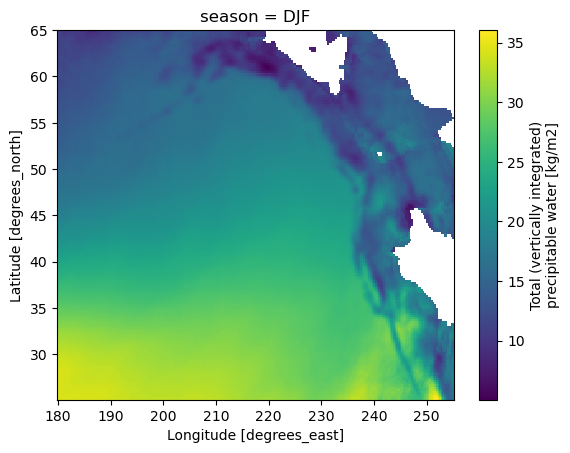

In [74]:
cesm_data_AR_smean['IWV'].sel(season='DJF').plot();

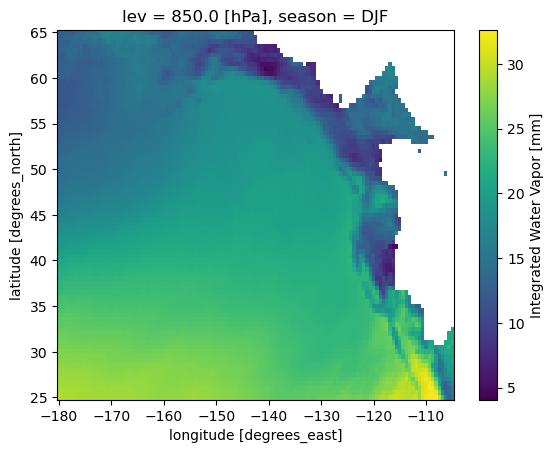

In [75]:
merra_data_AR_smean['IWV'].sel(season='DJF').plot();

### Remap CESM to MERRA grid

In [58]:
%%time
regridder = xe.Regridder(cesm_data_AR_smean, merra_data_AR_smean, "bilinear", periodic=True)
regridder

CPU times: user 8.17 s, sys: 323 ms, total: 8.49 s
Wall time: 8.89 s


xESMF Regridder 
Regridding algorithm:       bilinear 
Weight filename:            bilinear_170x241_81x121_peri.nc 
Reuse pre-computed weights? False 
Input grid shape:           (170, 241) 
Output grid shape:          (81, 121) 
Periodic in longitude?      True

In [59]:
%%time
cesm_data_AR_smean_merragrid = regridder(cesm_data_AR_smean, keep_attrs=True)
cesm_data_AR_smean_merragrid

CPU times: user 21.4 s, sys: 894 ms, total: 22.3 s
Wall time: 23.9 s


<xarray.Dataset>
Dimensions:  (season: 4, lat: 81, lon: 121)
Coordinates:
  * season   (season) object 'DJF' 'JJA' 'MAM' 'SON'
  * lat      (lat) float64 25.0 25.5 26.0 26.5 27.0 ... 63.0 63.5 64.0 64.5 65.0
    lev      float64 850.0
  * lon      (lon) float64 -180.0 -179.4 -178.8 -178.1 ... -106.2 -105.6 -105.0
Data variables:
    U850     (season, lat, lon) float32 dask.array<chunksize=(1, 81, 121), meta=np.ndarray>
    V850     (season, lat, lon) float32 dask.array<chunksize=(1, 81, 121), meta=np.ndarray>
    IWV      (season, lat, lon) float32 dask.array<chunksize=(1, 81, 121), meta=np.ndarray>
Attributes:
    regrid_method:  bilinear

In [60]:
cesm_data_AR_smean_merragrid = cesm_data_AR_smean_merragrid.persist()

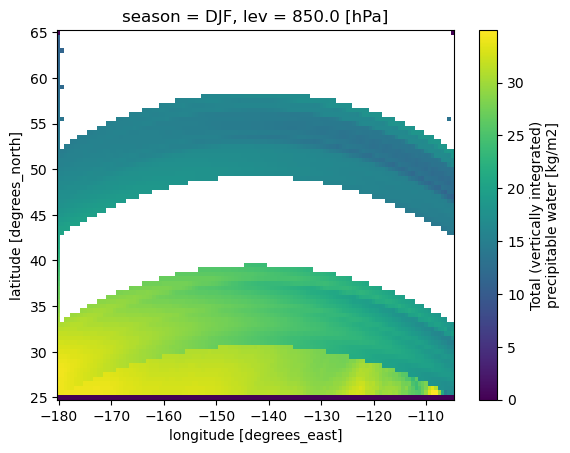

In [71]:
cesm_data_AR_smean_merragrid['IWV'].sel(season='DJF').plot();

In [61]:
# note variable name difference TMQ / IWV - resolved?
diff_smean = merra_data_AR_smean - cesm_data_AR_smean_merragrid
diff_smean

<xarray.Dataset>
Dimensions:  (lat: 81, lon: 121, season: 4)
Coordinates:
  * lat      (lat) float64 25.0 25.5 26.0 26.5 27.0 ... 63.0 63.5 64.0 64.5 65.0
    lev      float64 850.0
  * lon      (lon) float64 -180.0 -179.4 -178.8 -178.1 ... -106.2 -105.6 -105.0
  * season   (season) object 'DJF' 'JJA' 'MAM' 'SON'
Data variables:
    IWV      (season, lat, lon) float32 dask.array<chunksize=(1, 16, 65), meta=np.ndarray>
    U850     (season, lat, lon) float32 dask.array<chunksize=(1, 10, 65), meta=np.ndarray>
    V850     (season, lat, lon) float32 dask.array<chunksize=(1, 10, 65), meta=np.ndarray>

In [77]:
# try regridding one variable at a time
IWV_data_AR_smean_merragrid = regridder(cesm_data_AR_smean['IWV'], keep_attrs=True)
IWV_data_AR_smean_merragrid

<xarray.DataArray 'IWV' (season: 4, lat: 81, lon: 121)>
dask.array<astype, shape=(4, 81, 121), dtype=float32, chunksize=(1, 81, 121), chunktype=numpy.ndarray>
Coordinates:
  * season   (season) object 'DJF' 'JJA' 'MAM' 'SON'
  * lat      (lat) float64 25.0 25.5 26.0 26.5 27.0 ... 63.0 63.5 64.0 64.5 65.0
    lev      float64 850.0
  * lon      (lon) float64 -180.0 -179.4 -178.8 -178.1 ... -106.2 -105.6 -105.0
Attributes:
    long_name:      Total (vertically integrated) precipitable water
    units:          kg/m2
    title:          3-hr averaged/vertically integrated/CESM Water Vapor
    summary:        Create input for ClimateNet application
    creator:        Teagan King, tking@ucar.edu
    contact:        Teagan King, tking@ucar.edu
    script:         jupyter notebook at /glade/u/home/tking/cgnet/Data_Proces...
    conventions:    CF 1.0
    creation_date:  2023-02-17
    regrid_method:  bilinear

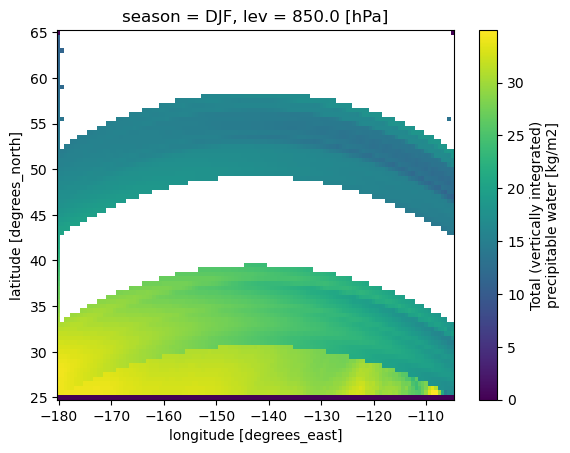

In [78]:
IWV_data_AR_smean_merragrid.sel(season='DJF').plot();

## TO DO: need to regrid globally

In [80]:
%%time
regridder = xe.Regridder(cesm_data, merra_dataset, "bilinear", periodic=True)
regridder

CPU times: user 16.2 s, sys: 677 ms, total: 16.9 s
Wall time: 19 s


xESMF Regridder 
Regridding algorithm:       bilinear 
Weight filename:            bilinear_768x1152_361x576_peri.nc 
Reuse pre-computed weights? False 
Input grid shape:           (768, 1152) 
Output grid shape:          (361, 576) 
Periodic in longitude?      True

In [82]:
%%time
cesm_data_merragrid = regridder(cesm_data, keep_attrs=True)
cesm_data_merragrid

CPU times: user 2.57 s, sys: 181 ms, total: 2.75 s
Wall time: 3.27 s


<xarray.Dataset>
Dimensions:  (time: 46720, lat: 361, lon: 576)
Coordinates:
  * time     (time) object 2000-01-01 00:00:00 ... 2015-12-31 21:00:00
  * lat      (lat) float64 -90.0 -89.5 -89.0 -88.5 -88.0 ... 88.5 89.0 89.5 90.0
  * lon      (lon) float64 -180.0 -179.4 -178.8 -178.1 ... 178.1 178.8 179.4
Data variables:
    U850     (time, lat, lon) float32 dask.array<chunksize=(1, 361, 576), meta=np.ndarray>
    V850     (time, lat, lon) float32 dask.array<chunksize=(1, 361, 576), meta=np.ndarray>
    TMQ      (time, lat, lon) float32 dask.array<chunksize=(1, 361, 576), meta=np.ndarray>
Attributes:
    regrid_method:  bilinear

## Fails here due to longitude grid differences
Either need to use global `cesm_AR` and subset before regridding, or change the coordinate system

In [89]:
cesm_AR_merra.coords['lon'] = (cesm_AR.coords['lon'] + 180) % 360 - 180
#cesm_AR_merra.sortby(cesm_AR_merra.lon)
cesm_AR_merra

<xarray.DataArray 'masks' (time: 46720, lat: 170, lon: 241)>
dask.array<sub, shape=(46720, 170, 241), dtype=int64, chunksize=(500, 170, 241), chunktype=numpy.ndarray>
Coordinates:
  * lat      (lat) float64 25.23 25.46 25.7 25.93 ... 64.19 64.42 64.65 64.89
  * time     (time) object 2000-01-01 00:00:00 ... 2015-12-31 21:00:00
  * lon      (lon) float64 -180.0 -179.7 -179.4 -179.1 ... -105.6 -105.3 -105.0

In [90]:
# sort of working for lons but for some reason failing on lats...
cesm_data_merragrid_AR = cesm_data_merragrid.where(cesm_AR_merra==1)
cesm_data_merragrid_AR

<xarray.Dataset>
Dimensions:  (time: 46720, lat: 0, lon: 121)
Coordinates:
  * time     (time) object 2000-01-01 00:00:00 ... 2015-12-31 21:00:00
  * lat      (lat) float64 
  * lon      (lon) float64 -180.0 -179.4 -178.8 -178.1 ... -106.2 -105.6 -105.0
Data variables:
    U850     (time, lat, lon) float32 dask.array<chunksize=(1, 0, 121), meta=np.ndarray>
    V850     (time, lat, lon) float32 dask.array<chunksize=(1, 0, 121), meta=np.ndarray>
    TMQ      (time, lat, lon) float32 dask.array<chunksize=(1, 0, 121), meta=np.ndarray>
Attributes:
    regrid_method:  bilinear

### All Variable Seasonal Climo Diffs Panel Plot
Or instead of diff plots, could show side by side MERRA/native grid CESM comparisons for input variables (due to differences in resolution)

In [62]:
for i, var in enumerate(('IWV', 'U850', 'V850')):
    print(var)
    print('AR timepoint diff ranges ',diff_smean[var].min().values, diff_smean[var].max().values)

IWV
AR timepoint diff ranges  -21.698528 47.21858
U850
AR timepoint diff ranges  -25.803236 26.729675
V850
AR timepoint diff ranges  -22.08132 27.261713


CPU times: user 3 s, sys: 71.2 ms, total: 3.07 s
Wall time: 3.67 s


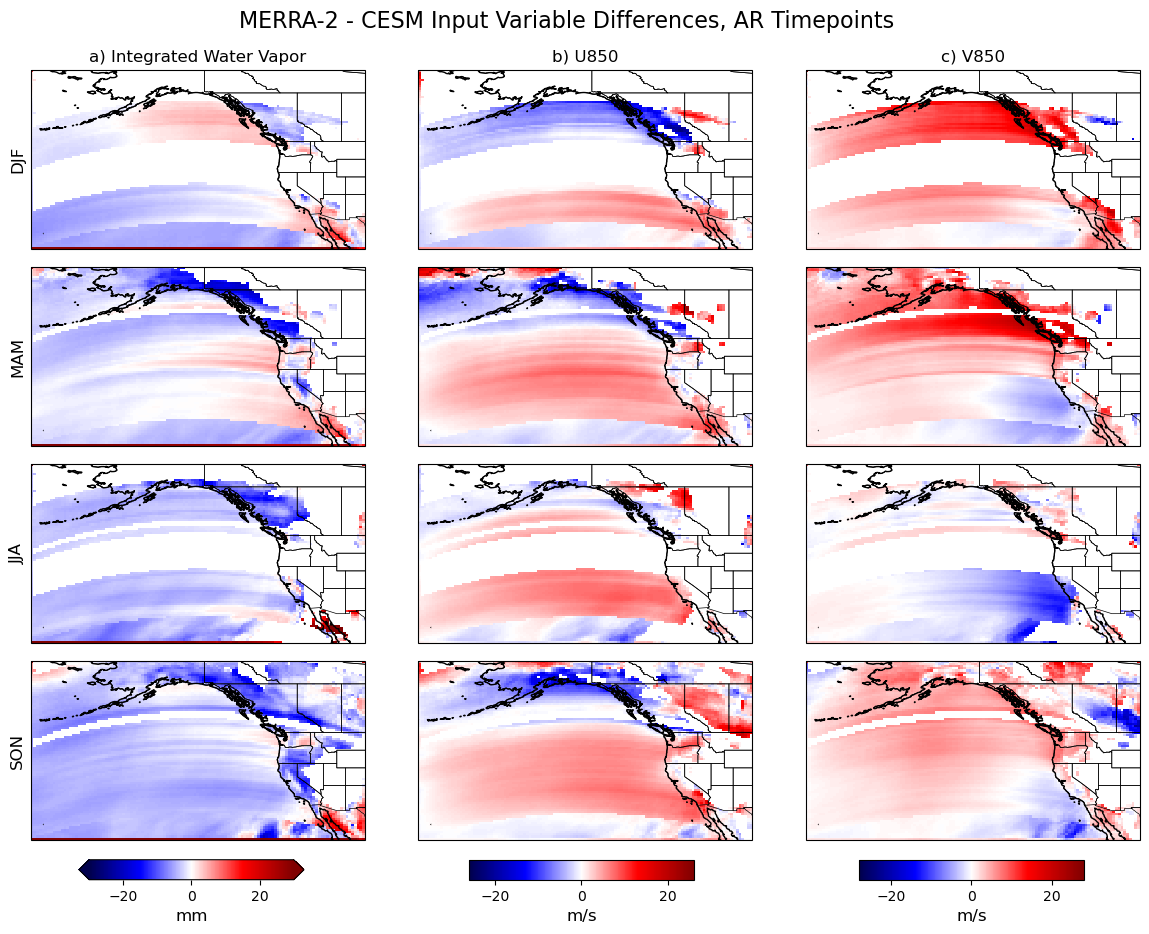

In [69]:
%%time
fig, ax = plt.subplots(4, 3, figsize=(15,10), subplot_kw={'projection': ccrs.PlateCarree(central_longitude=180.0)}) # figsize is width, height

cmap = mpl.colormaps.get_cmap('seismic')

# regional subset
lat_bounds_merra = slice(25,65)
lon_bounds_merra = slice(-180,-105)

for i, season in enumerate(('DJF', 'MAM', 'JJA', 'SON')):
    # TMQ/IWV
    lat = diff_smean.lat.sel(lat=lat_bounds)
    lon = diff_smean.lon.sel(lon=lon_bounds_merra)
    pc1 = ax[i,0].pcolormesh(lon, lat, diff_smean['IWV'].sel(season=season, lat=lat_bounds, lon=lon_bounds_merra), cmap=cmap, vmin=-30, vmax=30, transform=ccrs.PlateCarree())
    ax[i,0].coastlines(zorder=1)
    ax[i,0].add_feature(cfeature.STATES, zorder=2, linewidth=0.5)
    ax[i,0].set_ylabel(season, fontsize=12)
    ax[i,0].set_yticks([])
    if i==0:
        ax[i,0].set_title('a) Integrated Water Vapor', fontsize=12)

    # U850
    pc2 = ax[i,1].pcolormesh(lon, lat, diff_smean['U850'].sel(season=season, lat=lat_bounds, lon=lon_bounds_merra), cmap=cmap, vmin=-26, vmax=26, transform=ccrs.PlateCarree())
    #c2 = ax[i,1].contour(lon, lat, U850_diff_season_climo.sel(season=season, lat=lat_bounds, lon=lon_bounds_merra), transform=ccrs.PlateCarree())
    ax[i,1].coastlines(zorder=1)
    ax[i,1].add_feature(cfeature.STATES, zorder=2, linewidth=0.5)
    #ax[i,1].set_yticks([])
    if i==0:
        ax[i,1].set_title('b) U850', fontsize=12)

    # V850
    pc3 = ax[i,2].pcolormesh(lon, lat, diff_smean['V850'].sel(season=season, lat=lat_bounds, lon=lon_bounds_merra), cmap=cmap, vmin=-28, vmax=28, transform=ccrs.PlateCarree())
    ax[i,2].coastlines(zorder=1)
    ax[i,2].add_feature(cfeature.STATES, zorder=2, linewidth=0.5)
    #ax[i,2].set_yticks([])
    if i==0:
        ax[i,2].set_title('c) V850', fontsize=12)
    
# add colorbar for TMQ/IWV
cbar_1_ax = fig.add_axes([0.175, 0.07, 0.15, 0.02])
cbar_1 = plt.colorbar(pc1, cax=cbar_1_ax, orientation='horizontal', extend='both')
cbar_1.ax.set_xlabel('mm', fontsize=12);

# add colorbar for U850
cbar_2_ax = fig.add_axes([0.435, 0.07, 0.15, 0.02])
cbar_2 = plt.colorbar(pc2, cax=cbar_2_ax, orientation='horizontal')
cbar_2.ax.set_xlabel('m/s', fontsize=12);

# add colorbar for V850
cbar_3_ax = fig.add_axes([0.695, 0.07, 0.15, 0.02])
cbar_3 = plt.colorbar(pc3, cax=cbar_3_ax, orientation='horizontal')
cbar_3.ax.set_xlabel('m/s', fontsize=12);

# add suptitle
fig.suptitle('MERRA-2 - CESM Input Variable Differences, AR Timepoints', fontsize=16, y=0.94);

plt.subplots_adjust(wspace=0, hspace=0.1) 

#plt.savefig('../figures/toSCP/MERRA-CESM-allvars_2000-2015_byseason_WUS_diff.png', bbox_inches='tight')
#plt.savefig('../figures/toSCP/jeremy-1.png', bbox_inches='tight') # mistake version!

In [67]:
client.close()
cluster.close()